<a href="https://colab.research.google.com/github/NTHieu2k1/gender-classification/blob/main/notebooks/HieuNT_Gender_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare data:

In [1]:
!cp "drive/MyDrive/HieuNT - Gender Classification/gender_classification_dataset.zip" .

In [2]:
!unzip -q gender_classification_dataset -d ./dataset

# Import libraries & packages

In [3]:
%%capture
!pip install torchmetrics torchinfo torch_snippets

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import cv2 as cv
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchinfo import summary
from torchmetrics import Accuracy
from torch_snippets import *
from torch_snippets.torch_loader import Report

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'    # cuda means GPU
device

'cuda'

# Initially load the dataset:

In [6]:
train_df = pd.read_csv('dataset/train.csv')
train_df.head()

,path,label
0,female/beautiful-woman-good-looking-face-touch...,female
1,female/portrait-beautiful-asian-woman-with-bla...,female
2,male/istockphoto-1494324933-612x612.jpg,male
3,male/istockphoto-905028968-612x612.jpg,male
4,male/istockphoto-1191348064-612x612.jpg,male


# Convert into `Dataset` and `DataLoader` instances:

In [7]:
class GenderDataset(Dataset):
    def __init__(self, data_dir, csv_file, transform=None):
        super().__init__()
        self.data_dir = data_dir
        csv_path = os.path.join(self.data_dir, csv_file)
        self.df = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def load_image(self, idx):
        path = os.path.join(self.data_dir, self.df.iloc[idx, 0])
        image = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB)
        return image

    def __getitem__(self, idx):
        image = self.load_image(idx)
        label = self.df.iloc[idx, 1]
        label = torch.tensor([1.0]) if label == 'male' else torch.tensor([0.0])    # 0: Female, 1: Male
        if self.transform:
            image = self.transform(image)
        return image.to(device), label.to(device)

In [8]:
IMAGE_SIZE = 224

transform = T.Compose([
    T.ToTensor(),
    T.Resize(size=[IMAGE_SIZE, IMAGE_SIZE])
])

train_data = GenderDataset(data_dir='dataset', csv_file='train.csv', transform=transform)
test_data = GenderDataset(data_dir='dataset', csv_file='test.csv', transform=transform)

print(f'No. of samples in the training set: {len(train_data)}')
print(f'No. of samples in the test set: {len(test_data)}')

No. of samples in the training set: 320
No. of samples in the test set: 80


In [9]:
BATCH_SIZE = 32

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

print(f'No. of mini-batches in the training set: {len(train_loader)}')
print(f'No. of mini-batches in the test set: {len(test_loader)}')

No. of mini-batches in the training set: 10
No. of mini-batches in the test set: 3


# Inspect some samples in the training set:

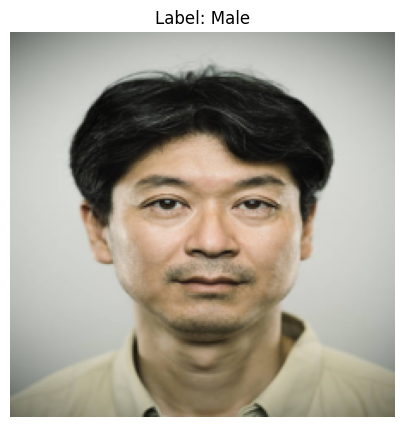

torch.Size([3, 224, 224])
tensor([1.], device='cuda:0')


In [10]:
idx = 30
image, label = train_data[idx]
image_show = image.cpu().permute((1, 2, 0))
# plt.imshow(image_show)
# plt.title(f'Label: {"Male" if label == 1 else "Female"}')
show(image_show, title=f'Label: {"Male" if label == 1 else "Female"}', sz=5)
print(image.shape)
print(label);

# Helper functions:

In [11]:
def prepare_for_training(model: nn.Module, lr: float, device: torch.device = device):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    accuracy = Accuracy(task='binary').to(device)
    return criterion, optimizer, accuracy

In [12]:
def train_step(model: nn.Module, batch, criterion: nn.Module, optimizer: optim.Optimizer, accuracy, device: torch.device = device):
    model.train()
    X, y = batch
    y_hat = model(X)
    loss = criterion(y_hat, y)
    acc = accuracy(y_hat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

def test_step(model: nn.Module, batch, criterion: nn.Module, accuracy, device: torch.device = device):
    model.eval()
    with torch.inference_mode():
        X, y = batch
        y_hat = model(X)
        loss = criterion(y_hat, y)
        acc = accuracy(y_hat, y)
    return loss.item(), acc.item()

In [13]:
def fit(model, train_loader, test_loader, criterion, optimizer, accuracy, epochs, device=device):
    log = Report(epochs)
    for epoch in range(epochs):
        N = len(train_loader)
        for idx, batch in enumerate(train_loader):
            train_loss, train_acc = train_step(model, batch, criterion, optimizer, accuracy, device)
            log.record(epoch + (idx+1)/N, train_loss=train_loss, train_acc=train_acc, end='\r')
        N = len(test_loader)
        for idx, batch in enumerate(test_loader):
            test_loss, test_acc = test_step(model, batch, criterion, accuracy, device)
            log.record(epoch + (idx+1)/N, test_loss=test_loss, test_acc=test_acc, end='\r')
        log.report_avgs(epoch+1)
    return log

# Attempt 1: Build the baseline model (based on VGG13 architecture):

In [14]:
def VGGBlock(input_dim, n_filters, kernel_size, stride=1, padding=None, n_repeat=1, batch_norm=False):
    block = nn.Sequential()
    for i in range(n_repeat):
        if i == 0:
            block.append(nn.Conv2d(input_dim, n_filters, kernel_size=kernel_size, stride=stride, padding=padding))
        else:
            block.append(nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, stride=stride, padding=padding))
        if batch_norm:
            block.append(nn.BatchNorm2d(n_filters))
        block.append(nn.ReLU())
    block.append(nn.MaxPool2d(2))
    return block

In [15]:
class VGG13Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.conv_block = nn.Sequential(
            VGGBlock(input_dim, 64, 3, padding='same', n_repeat=2),
            VGGBlock(64, 128, 3, padding='same', n_repeat=2),
            VGGBlock(128, 256, 3, padding='same', n_repeat=2),
            VGGBlock(256, 512, 3, padding='same', n_repeat=2),
            VGGBlock(512, 512, 3, padding='same', n_repeat=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, output_dim)
        )

    def forward(self, x):
        return self.classifier(self.conv_block(x))

In [16]:
model_0 = VGG13Model(input_dim=3, output_dim=1).to(device)    # Only 2 classes => Binary classification
summary(model_0, input_size=[32, 3, 224, 224], col_names=['input_size', 'output_size', 'num_params', 'trainable'], col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG13Model (VGG13Model)                  [32, 3, 224, 224]    [32, 1]              --                   True
├─Sequential (conv_block)                [32, 3, 224, 224]    [32, 512, 7, 7]      --                   True
│    └─Sequential (0)                    [32, 3, 224, 224]    [32, 64, 112, 112]   --                   True
│    │    └─Conv2d (0)                   [32, 3, 224, 224]    [32, 64, 224, 224]   1,792                True
│    │    └─ReLU (1)                     [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    │    └─Conv2d (2)                   [32, 64, 224, 224]   [32, 64, 224, 224]   36,928               True
│    │    └─ReLU (3)                     [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    │    └─MaxPool2d (4)                [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Sequential (1

In [17]:
criterion, optimizer, accuracy = prepare_for_training(model_0, lr=1e-3)

In [18]:
log = fit(model_0, train_loader, test_loader, criterion, optimizer, accuracy, epochs=10)

EPOCH: 1.000  test_acc: 0.500  test_loss: 0.696  train_acc: 0.503  train_loss: 1.014  (8.29s - 74.58s remaining)
EPOCH: 2.000  test_acc: 0.500  test_loss: 0.694  train_acc: 0.484  train_loss: 0.697  (15.24s - 60.96s remaining)
EPOCH: 3.000  test_acc: 0.500  test_loss: 0.693  train_acc: 0.525  train_loss: 0.692  (22.72s - 53.01s remaining)
EPOCH: 4.000  test_acc: 0.500  test_loss: 0.693  train_acc: 0.487  train_loss: 0.694  (29.80s - 44.70s remaining)
EPOCH: 5.000  test_acc: 0.500  test_loss: 0.693  train_acc: 0.512  train_loss: 0.693  (37.22s - 37.22s remaining)
EPOCH: 6.000  test_acc: 0.500  test_loss: 0.693  train_acc: 0.487  train_loss: 0.693  (44.61s - 29.74s remaining)
EPOCH: 7.000  test_acc: 0.500  test_loss: 0.693  train_acc: 0.503  train_loss: 0.693  (51.74s - 22.17s remaining)
EPOCH: 8.000  test_acc: 0.500  test_loss: 0.693  train_acc: 0.516  train_loss: 0.693  (59.27s - 14.82s remaining)
EPOCH: 9.000  test_acc: 0.500  test_loss: 0.693  train_acc: 0.475  train_loss: 0.694  (66

100%|██████████| 111/111 [00:00<00:00, 10852.65it/s]


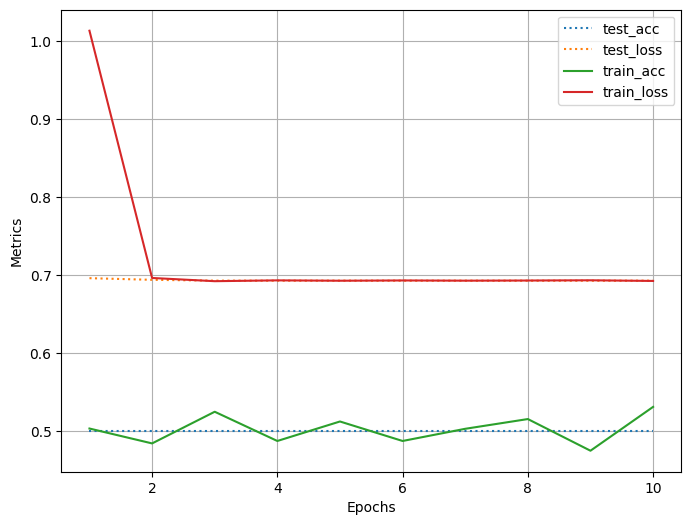

In [19]:
log.plot_epochs()

Build and train the model from scratch, this seems the model is still underfitting (as the accuracy is only around 50% on both two sets).

Let's try transfer learning for this architecture and check it out.

# Attempt 2: Utilize transfer learning via a pre-trained VGG13 model

In [20]:
from torchvision import models

vgg13_weights = models.VGG13_Weights.DEFAULT
vgg13_transform = vgg13_weights.transforms()
vgg13_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [21]:
vgg13_transform = T.Compose([
    T.ToTensor(),
    T.Resize(256),
    T.CenterCrop(224),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [22]:
train_data = GenderDataset(data_dir='dataset', csv_file='train.csv', transform=vgg13_transform)
test_data = GenderDataset(data_dir='dataset', csv_file='test.csv', transform=vgg13_transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [23]:
# Model building
model_1 = models.vgg13(weights=vgg13_weights)
for param in model_1.features.parameters():
    param.requires_grad = False
model_1.classifier = nn.Sequential(
    nn.Linear(7*7*512, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1)
)

summary(model_1, input_size=[32, 3, 224, 224], col_names=['input_size', 'output_size', 'num_params', 'trainable'], col_width=20,
        row_settings=['var_names'])

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth
100%|██████████| 508M/508M [00:04<00:00, 132MB/s]


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1]              --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (

In [24]:
criterion, optimizer, accuracy = prepare_for_training(model_1, lr=1e-3)

In [25]:
log = fit(model_1, train_loader, test_loader, criterion, optimizer, accuracy, epochs=10)

EPOCH: 1.000  test_acc: 0.891  test_loss: 0.372  train_acc: 0.649  train_loss: 4.081  (6.20s - 55.82s remaining)
EPOCH: 2.000  test_acc: 0.927  test_loss: 0.306  train_acc: 0.925  train_loss: 0.231  (11.52s - 46.08s remaining)
EPOCH: 3.000  test_acc: 0.938  test_loss: 0.240  train_acc: 0.984  train_loss: 0.051  (17.60s - 41.07s remaining)
EPOCH: 4.000  test_acc: 0.948  test_loss: 0.272  train_acc: 0.994  train_loss: 0.016  (23.10s - 34.65s remaining)
EPOCH: 5.000  test_acc: 0.948  test_loss: 0.354  train_acc: 0.997  train_loss: 0.004  (28.64s - 28.64s remaining)
EPOCH: 6.000  test_acc: 0.948  test_loss: 0.427  train_acc: 1.000  train_loss: 0.000  (34.69s - 23.13s remaining)
EPOCH: 7.000  test_acc: 0.917  test_loss: 0.481  train_acc: 1.000  train_loss: 0.000  (40.04s - 17.16s remaining)
EPOCH: 8.000  test_acc: 0.906  test_loss: 0.522  train_acc: 1.000  train_loss: 0.000  (46.30s - 11.58s remaining)
EPOCH: 9.000  test_acc: 0.906  test_loss: 0.535  train_acc: 1.000  train_loss: 0.000  (51

100%|██████████| 111/111 [00:00<00:00, 18701.26it/s]


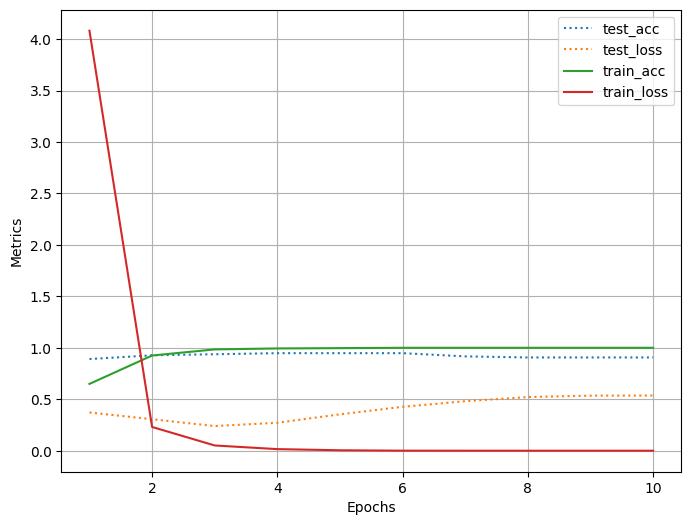

In [26]:
log.plot_epochs()

This is a **HUGE** improvement. Now this model performs much better than previous one, but it seems to be overfitting.

Let's try with `Dropout` applied on the top layers, as well as decreasing the number of hidden units.

In [27]:
model_2 = models.vgg13(weights=vgg13_weights)
for param in model_2.features.parameters():
    param.requires_grad = False
model_2.classifier = nn.Sequential(
    nn.Linear(7*7*512, 2048),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(2048, 2048),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(2048, 1)
)

summary(model_2, input_size=[32, 3, 224, 224], col_names=['input_size', 'output_size', 'num_params', 'trainable'], col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1]              --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (

In [28]:
criterion, optimizer, accuracy = prepare_for_training(model_2, lr=1e-3)

In [29]:
log = fit(model_2, train_loader, test_loader, criterion, optimizer, accuracy, epochs=10)

EPOCH: 1.000  test_acc: 0.906  test_loss: 0.278  train_acc: 0.726  train_loss: 1.205  (6.01s - 54.06s remaining)
EPOCH: 2.000  test_acc: 0.906  test_loss: 0.195  train_acc: 0.938  train_loss: 0.163  (11.19s - 44.77s remaining)
EPOCH: 3.000  test_acc: 0.958  test_loss: 0.281  train_acc: 0.988  train_loss: 0.030  (17.05s - 39.79s remaining)
EPOCH: 4.000  test_acc: 0.948  test_loss: 0.328  train_acc: 0.997  train_loss: 0.011  (22.37s - 33.56s remaining)
EPOCH: 5.000  test_acc: 0.948  test_loss: 0.386  train_acc: 1.000  train_loss: 0.001  (27.50s - 27.50s remaining)
EPOCH: 6.000  test_acc: 0.938  test_loss: 0.406  train_acc: 1.000  train_loss: 0.000  (33.52s - 22.35s remaining)
EPOCH: 7.000  test_acc: 0.938  test_loss: 0.424  train_acc: 1.000  train_loss: 0.000  (38.67s - 16.57s remaining)
EPOCH: 8.000  test_acc: 0.938  test_loss: 0.444  train_acc: 1.000  train_loss: 0.000  (44.71s - 11.18s remaining)
EPOCH: 9.000  test_acc: 0.948  test_loss: 0.458  train_acc: 1.000  train_loss: 0.000  (49

100%|██████████| 111/111 [00:00<00:00, 16635.14it/s]


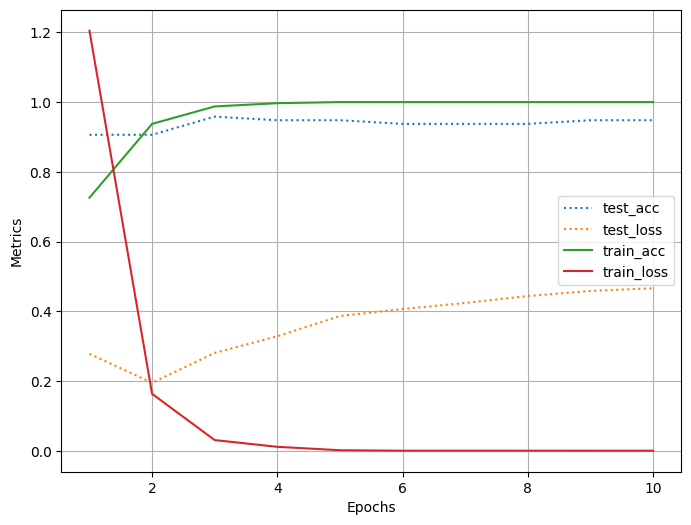

In [30]:
log.plot_epochs()

This model now have only 1/2 of number of parameters than the previous model.

And also, the test accuracy of this version is a bit better than previous (**95%** compare to 90% as previous).

However, overfitting issue still exists.

This might be due to our dataset is quite small (only 400 images total, 320 for training & 80 for test set).

# Save the best model:

In [31]:
torch.save(model_2.state_dict(), f='gender_classifier_250415.pt')

# Make predictions on a custom image:

In [33]:
best_model = models.vgg13(weights=None)
best_model.classifier = nn.Sequential(
    nn.Linear(7*7*512, 2048),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(2048, 2048),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(2048, 1)
)
best_model.load_state_dict(torch.load('gender_classifier_250415.pt'))

<All keys matched successfully>

In [34]:
from google.colab import files
_ = files.upload()

Saving profile.jpg to profile.jpg


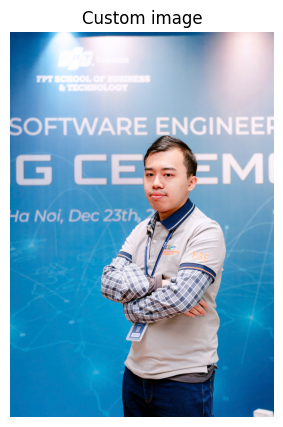

In [35]:
# Read image
image_orig = cv.cvtColor(cv.imread('profile.jpg'), cv.COLOR_BGR2RGB)
show(image_orig, title='Custom image', sz=5);

In [36]:
# Apply transform
image = vgg13_transform(image_orig)[None].to(device)
image.shape

torch.Size([1, 3, 224, 224])

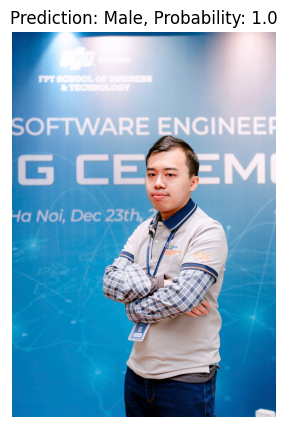

In [37]:
# Feed into the model (model_2)
with torch.inference_mode():
    logits = model_2(image)
    pred = torch.sigmoid(logits).cpu().item()
    pred_class = 'Male' if pred >= 0.5 else 'Female'
    pred_prob = pred if pred >= 0.5 else 1-pred
    show(image_orig, title=f'Prediction: {pred_class}, Probability: {round(pred_prob, 4)}', sz=5);

# (BONUS) How to deal when the data gets bigger?

* Gather the bigger dataset, pre-process, re-train the model and compare with the previous version to check if any improvement exist.
* In pre-processing steps, crop the facial region of the image.
* If possible, this problem might be extended to perform face detection & gender classification in real time (*via object detection models*).